# <center>Trabajo Práctico 1</center>

## Grupo 4:


| Nombre  | Padrón |
| ------------- | ------------- |
| Ian Gauler | 109437  |
| Valentina Gemetto  | 109667  |
| Agustin Puglisi  | 104245 |
| Ezequiel Vilardo  | 104980  |

Generador de números al azar elegido:
# <center>Mersenne Twister</center>

---

# Importación de librerías

Para este Trabajo Práctico necesitaremos usar varias funciones de librerías de Python. A continuación las importaremos:

In [1]:
# Gráficas y visualización
from matplotlib import pyplot as plt
import seaborn as sns

# Estadísticas y tests
from scipy.stats import chi2, kstest
import scipy.stats as stats

# Cálculos y matemáticas
import math
from sympy import Symbol, integrate

# Manipulación de datos y arreglos
import numpy as np

---

# Ejercicio 1:

Sobre el generador de números al azar elegido, se pide:
* Implementarlo en función de la especificación del mismo.
* Modificarlo (si aplica) para obtener números al azar entre 0 y 1
* Realizar los gráficos que se consideren adecuados para mostrar las distribuciones de números
pseudoaleatorios generados (explicar que se busca interpretar con cada uno de los gráficos)

---

## Implementacion

Lo primero que haremos es setear las constantes del algoritmo que cumplen con una serie de condiciones:
* W: word size (in number of bits)
* N: degree of recurrence
* M: middle word, an offset used in the recurrence relation defining the series x, 1 <= m < n
* R: separation point of one word, or the number of bits of the lower bitmask, 0 <= r <= w - 1
* A: coefficients of the rational normal form twist matrix
* B, C: TGFSR(R) tempering bitmasks
* S, T: TGFSR(R) tempering bit shifts
* U, D, L: additional Mersenne Twister tempering bit shifts/masks

Vamos a tomar las constantes del
[MT19937, Motor de Mersenne twister de 32 bits (Matsumoto y Nishimura, 1998)](https://learn.microsoft.com/es-es/cpp/standard-library/mersenne-twister-engine-class?view=msvc-170).\
Ya que según nuestro paper, es el que mejor se comporta en cuanto a la distribución de los números generados. Con un periodo de hasta $2^{19937}-1$.

In [2]:
W = 32
N = 624
M = 397
R = 31
A = 0x9908B0DF
U = 11
D = 0xFFFFFFFF
S = 7
B = 0x9D2C5680
T = 15
C = 0xEFC60000
L = 18
F = 1812433253
W_MASK = pow(2, W) - 1

### Pseudocodigo de ejemplo hecho en C

De [Wikipedia](https://en.wikipedia.org/wiki/Mersenne_Twister) obtenemos un pseudocódigo del algoritmo hecho en C:

```c
// Create a length n array to store the state of the generator
 int[0..n-1] MT
 int index := n+1
 const int lower_mask = (1 << r) - 1 // That is, the binary number of r 1's
 const int upper_mask = lowest w bits of (not lower_mask)

 // Initialize the generator from a seed
 function seed_mt(int seed) {
     index := n
     MT[0] := seed
     for i from 1 to (n - 1) { // loop over each element
         MT[i] := lowest w bits of (f * (MT[i-1] xor (MT[i-1] >> (w-2))) + i)
     }
 }

 // Extract a tempered value based on MT[index]
 // calling twist() every n numbers
 function extract_number() {
     if index >= n {
         if index > n {
           error "Generator was never seeded"
           // Alternatively, seed with constant value; 5489 is used in reference C code[54]
         }
         twist()
     }

     int y := MT[index]
     y := y xor ((y >> u) and d)
     y := y xor ((y << s) and b)
     y := y xor ((y << t) and c)
     y := y xor (y >> l)

     index := index + 1
     return lowest w bits of (y)
 }

 // Generate the next n values from the series x_i
 function twist() {
     for i from 0 to (n-1) {
         int x := (MT[i] and upper_mask)
                   | (MT[(i+1) mod n] and lower_mask)
         int xA := x >> 1
         if (x mod 2) != 0 { // lowest bit of x is 1
             xA := xA xor a
         }
         MT[i] := MT[(i + m) mod n] xor xA
     }
     index := 0
 }
```

### Implementamos el código en Python:

Como el algoritmo implementado genera valores entre 0 y 2^32, si buscamos modificarlo para que su salida este entre 0 y 1, lo único que debemos hacer es dividir el número aleatorio obtenido por 2^32 - 1.

In [3]:
# Genero una mascara superior y inferior
lower_mask = (
    1 << R
) - 1  # Número binario que consiste en mover un 1, R veces a la izquierda y restarle 1
upper_mask = (~lower_mask) & W_MASK


# Definimos la clase MT19937 que genera numeros pseudoaleatorios de 32 bits a partir de una semilla
class MT19937:
    def __init__(self, seed):
        """
        Inicializa el generador mersenne-twister con una semilla
        """
        self.index = N
        self.state = [0] * N
        self._seed(seed)

    def _seed(self, seed):
        """
        Inicializa la semilla para el generador
        """
        self.state[0] = seed & W_MASK
        for i in range(1, N):
            self.state[i] = (
                F * (self.state[i - 1] ^ (self.state[i - 1] >> (W - 2))) + i
            ) & W_MASK

    # Genera los siguientes N numeros pseudoaleatorios
    def twist(self):
        for i in range(N):
            x = (self.state[i] & upper_mask) + (self.state[(i + 1) % N] & lower_mask)
            xA = x >> 1
            if x % 2 != 0:
                xA ^= A
            self.state[i] = self.state[(i + M) % N] ^ xA
        self.index = 0

    # Extrae el siguiente numero segun el indice y si es necesario llama al "twist" para volver a generar mas numeros
    def next(self):
        if self.index >= N:
            self.twist()

        y = self.state[self.index]
        y ^= (y >> U) & D
        y ^= (y << S) & B
        y ^= (y << T) & C
        y ^= y >> L

        self.index += 1
        return y & W_MASK

    # Modificacion para generar numeros entre 0 y 1
    def next_uniforme(self):
        """
        Genera un numero pseudoaleatorio entre 0 y 1
        """
        return mt.next() / (pow(2, W) - 1)


# Realizamos una prueba de los primeros 10 numeros generados
mt = MT19937(0)
for i in range(10):
    print(mt.next())
# genera numeros entre 0 y 2^w, en este caso 2^32

2357136044
2546248239
3071714933
3626093760
2588848963
3684848379
2340255427
3638918503
1819583497
2678185683


### Comprobamos que funcione de manera correcta

Lo probamos con una muestra grande

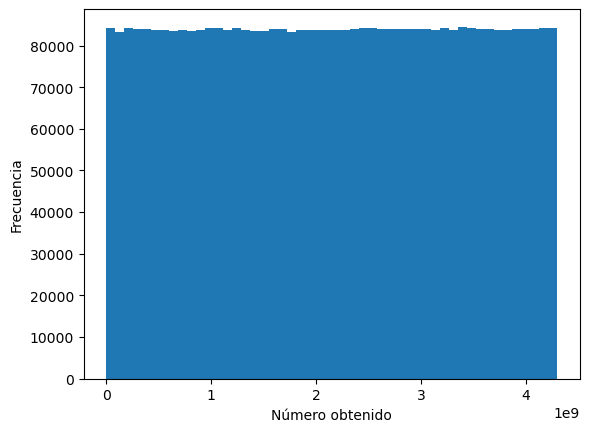

In [4]:
# Con una generacion bastante grande - Ejecutar solo cuando sea necesario
mt = MT19937(0)
resultado = [mt.next() for _ in range(pow(2, 22))]
plt.hist(resultado, 50)

plt.ylabel("Frecuencia")
plt.xlabel("Número obtenido")

plt.show()

Claramente, la distribución se observa uniforme. Ahora, veamos qué sucede cuando creamos una muestra de menor tamaño

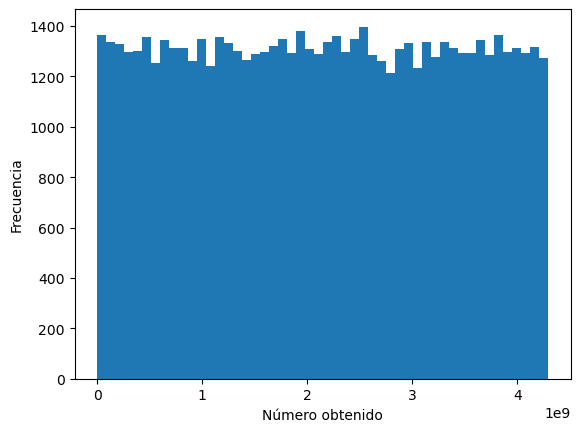

In [5]:
mt = MT19937(0)
resultado = [mt.next() for _ in range(pow(2, 16))]
plt.hist(resultado, 50)

plt.ylabel("Frecuencia")
plt.xlabel("Número obtenido")

plt.show()

Al reducir la cantidad, podemos ver que la generacion sigue siendo uniforme pero con unos pequeños picos.

## Gráficos correspondientes

Observamos un gráfico para la salida entre valores 0 y 1.

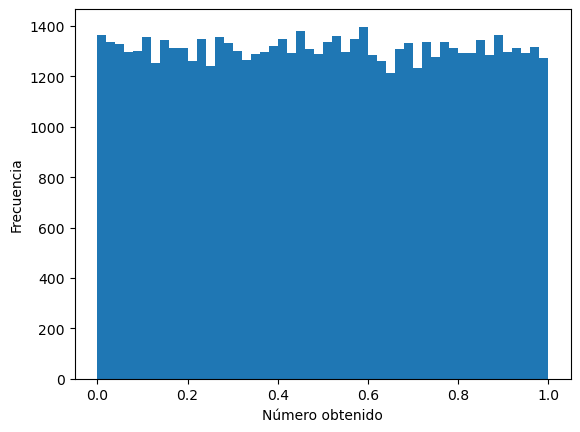

In [6]:
mt = MT19937(0)
resultado = [mt.next_uniforme() for _ in range(pow(2, 16))]
plt.hist(resultado, 50)


plt.ylabel("Frecuencia")
plt.xlabel("Número obtenido")

plt.show()

Podemos observar que se mantiene la uniformidad en la salida pero dentro de los nuevos valores buscados.



---



# Ejercicio 2


En este ejercicio se busca aplicar distintos test estadísticos vistos en la materia para evaluar tanto el comportamiento del generador de números pseudoaleatorios elegido como el comportamiento del generador implementado por otro grupo. El grupo al cual deben evaluar el generador se encuentra en la planilla de grupos en Drive.

Para esta tarea se debe solicitar al otro equipo uno o más lotes de números generado de los tamaños que se necesiten. El equipo que haya generado los números debe incluir en la notebook entregada el código utilizado
para generar los mismos.

a) Sobre los generadores implementados en el ejercicio 1:
* Proponer, y realizar,  al menos 3 tests para evaluar su comportamiento.
* Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.

b) Sobre el generador implementado por el grupo asignado:
* Proponer, y realizar,  al menos 3 tests para evaluar su comportamiento.
* Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.
* Comparar los resultados obtenidos para este generador con los obtenidos en el punto a

---

Definimos el nivel de significación que usaremos en los tests

In [7]:
ALPHA = 0.05

Definimos nuestra hipótesis nula $(H_0)$ y la hipótesis alternativa $(H_1)$ que se usará a lo largo de los test:

$H_0$: Los datos siguen una distribución de Poisson.\
$H_1$: Los datos no siguen una distribución de Poisson.

Calculamos con los valores observados la decisión del test.

Para este ejercicio vamos a usar 3 sets de tamaños diferentes

In [8]:
mt = MT19937(0)

MUESTRA_32 = [mt.next_uniforme() for _ in range(32)]
MUESTRA_256 = [mt.next_uniforme() for _ in range(256)]
MUESTRA_4096 = [mt.next_uniforme() for _ in range(4096)]

## Test Kolmogorov-Smirnov

El test de Kolmogorov-Smirnov nos permite determinar qué tanto se aproxima nuestra funcion de probabilidad a otra. En este caso nos interesa utilizar el test para comparar nuestras muestras generadas con una distribucion uniforme.

In [9]:
def kolmogorov_test(muestra, func_distri_acum_prueba):
    estadistico, pvalue = kstest(muestra, func_distri_acum_prueba)
    print(f"Estadistico = {estadistico}")
    print(f"p-value     = {pvalue}\n")

    if pvalue > ALPHA:
        print("No hay evidencia para rechazar H0")
    else:
        print("Rechazamos H0")


def graficar_kolmogorov_test(muestra_obs, func_distr_acum, nombre_distr):
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(data=muestra_obs, label="Empírica", color="r")
    x = np.linspace(0, 1, len(muestra_obs))

    plt.plot(x, func_distr_acum, label=nombre_distr, color="b")
    plt.grid(linestyle="--", color="black")
    plt.title("Prueba de Kolmogorov-Smirnov")
    plt.legend(title="Referencia")
    plt.ylabel("F(x)")
    plt.xlabel("x")
    plt.show()

Aplicamos el test a nuestras 3 muestras y las comparamos en un grafico contra la distribudicon uniforme entre 0 y 1.

Comenzamos con nuestra pequeña muestra de 32 elementos.

Estadistico = 0.19594152140976895
p-value     = 0.14956241747051857

No hay evidencia para rechazar H0


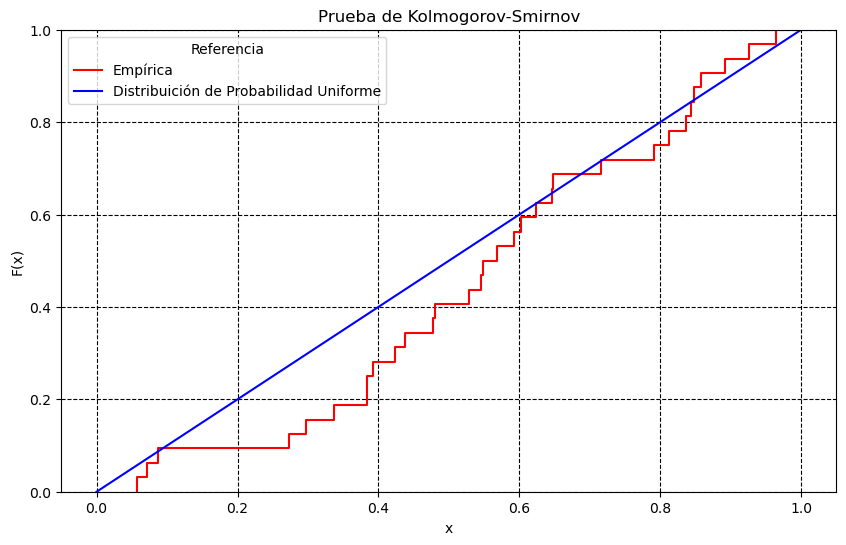

In [10]:
kolmogorov_test(MUESTRA_32, stats.uniform.cdf)
graficar_kolmogorov_test(
    MUESTRA_32,
    np.linspace(0, 1, len(MUESTRA_32)),
    "Distribuición de Probabilidad Uniforme",
)

Es posible notar que nuestra muestra presenta la intención de seguir una distribución uniforme. Sin embargo, debido a la limitada cantidad de números en la muestra, se pueden observar variaciones notables en la probabilidad acumulada a medida que se atraviesan ciertos valores. Estas variaciones pueden describirse como 'escalones' o 'saltos' en la distribución de probabilidad acumulada.

Estadistico = 0.04661447235860883
p-value     = 0.6171264019181358

No hay evidencia para rechazar H0


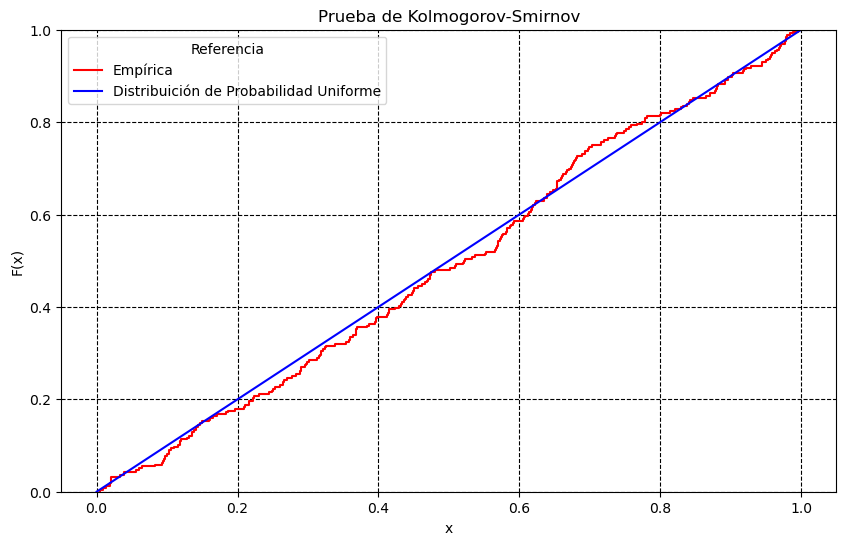

In [11]:
kolmogorov_test(MUESTRA_256, stats.uniform.cdf)
graficar_kolmogorov_test(
    MUESTRA_256,
    np.linspace(0, 1, len(MUESTRA_256)),
    "Distribuición de Probabilidad Uniforme",
)

Al aumentar el tamaño de la muestra estos saltos ya no son tan visibles y puede observarse que para ciertos intervalos la probabilidad acumulada se vuelve bastante similar a la de la uniforme.

Estadistico = 0.012011910071476062
p-value     = 0.5913771995058028

No hay evidencia para rechazar H0


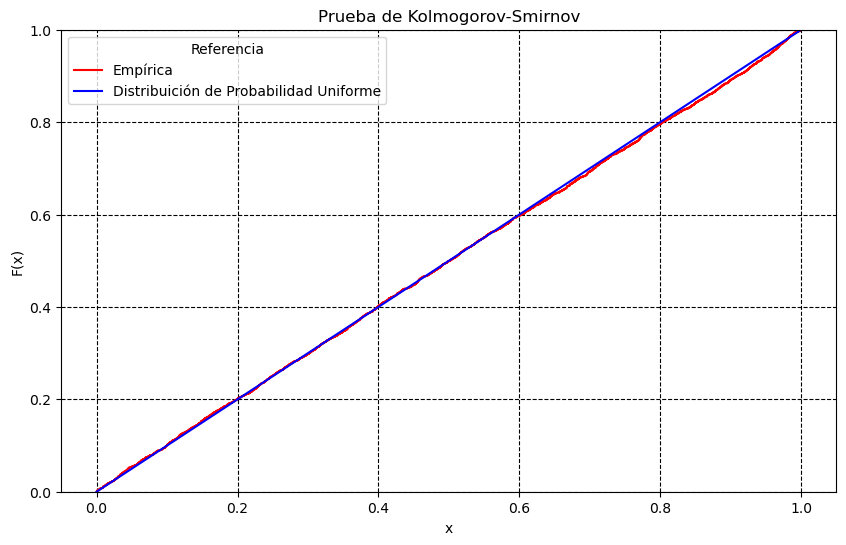

In [12]:
kolmogorov_test(MUESTRA_4096, stats.uniform.cdf)
graficar_kolmogorov_test(
    MUESTRA_4096,
    np.linspace(0, 1, len(MUESTRA_4096)),
    "Distribuición de Probabilidad Uniforme",
)

Finalmente, con una muestra mucho mas grande que la anterior, vemos que la linea de la probiblidad acumulada empirica se 'suaviza', ya no se ven aumentos repentinos en la probabilidad y a mayor cantidad de numeros en la muestra mas se aproximara a la funcion de probabilidad acumulada de la uniforme.

Al aumentar nuestro número de muestras, el test se vuelve más preciso. Con esto podemos comprobar que la probabilidad de que el test de Kolmogorov-Smirnov rechace la hipótesis nula disminuye (se rechaza la hipótesis cuando $p_{valor} \leq \alpha$).

## Test Frecuencia - Chi Cuadrado

La fórmula para calcular el estadístico de $\chi_{k-1}^2$ es la siguiente:

$$\chi_{k-1}^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i} \quad \text{con}\ \quad
\substack{
  \mathstrut \chi_{k-1}^2 = \text{Estadistico de chi-cuadrado} \\
  \mathstrut O_i = \text{Frecuencia Observada} \\
  \mathstrut E_i = \text{Frecuencia Obtenida}
}
$$

Utilizaremos el nivel de significancia planteado arriba para los tests.

Entonces definimos nuestra hipótesis nula $(H_0)$ y la hipótesis alternativa $(H_1)$:

$H_0$: Los datos siguen una distribución de Poisson.\
$H_1$: Los datos no siguen una distribución de Poisson.

Calculamos con los valores observados la decisión del test:

Para que las graficos sean mas claros vamos "discretizar" la muestra, aplanar los valores dentro de un rango a el piso de ese rango.

In [13]:
def discretizador(numero):
    if numero < 1 / 10:
        return 1
    elif numero < 2 / 10:
        return 2
    elif numero < 3 / 10:
        return 3
    elif numero < 4 / 10:
        return 4
    elif numero < 5 / 10:
        return 5
    elif numero < 6 / 10:
        return 6
    elif numero < 7 / 10:
        return 7
    elif numero < 8 / 10:
        return 8
    elif numero < 9 / 10:
        return 9
    else:
        return 10


def frecuencias(muestra):
    frecuencias = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for numero in muestra:
        frecuencias[discretizador(numero) - 1] = (
            frecuencias[discretizador(numero) - 1] + 1
        )
    return frecuencias


def frecuencia_chi2_test(muestra):
    resultados = frecuencias(muestra)
    lanzamientos = sum(resultados)
    grados_libertad = 9

    D2 = sum([(fO - 1 / 10 * lanzamientos) ** 2 for fO in resultados]) / (
        1 / 10 * lanzamientos
    )

    limiteSuperior = chi2.ppf(1 - ALPHA, df=grados_libertad)
    print("Limite superior: {:.2f} ".format(limiteSuperior))
    print("Estadistico: {:.2f} ".format(D2))

    if D2 <= limiteSuperior:
        print("No hay evidencia para rechazar H0")
    else:
        print("Rechazamos H0")

Definimos las funciones que graficarán los resultados de los tests para obtener una mejor visualización.

In [57]:
def graficar_chi2_test(grados_libertad):
    # Gráfico de la densidad de probabilidad de Chi-cuadrado
    limiteSuperior = stats.chi2.ppf(1 - ALPHA, df=grados_libertad)

    # Valores para el eje x (valores de Chi-cuadrado)
    x = np.linspace(0, 30, 1000)

    densidad_proba = stats.chi2.pdf(x, grados_libertad)
    plt.figure(figsize=(12, 7))
    plt.plot(
        x, densidad_proba, label=f"Chi-cuadrado ({grados_libertad} grados de libertad)"
    )
    plt.fill_between(
        x,
        densidad_proba,
        where=(x > limiteSuperior),
        alpha=0.3,
        color="red",
        label=f"Zona de rechazo (alpha={ALPHA})",
    )

    # Línea vertical en el limiteSuperior
    plt.axvline(
        limiteSuperior,
        color="red",
        linestyle="--",
        label=f"Cuantil ({1 - ALPHA} de confianza)",
    )

    plt.xlabel("Valor de Chi-cuadrado")
    plt.ylabel("Densidad de probabilidad")
    plt.title("Distribución de Chi-cuadrado y Zona de Rechazo")
    plt.legend(loc="upper right")

    plt.show()


# Graficamos las ocurrencias por rango
def graficar_ocurrencias(muestra):
    resultados = frecuencias(muestra)
    print("Frecuencias: ", resultados)
    sns.histplot(data=muestra, bins=10)
    plt.grid(linestyle="--", color="black")
    plt.title("Frecuencia relativa de los números generados", size=20)
    plt.ylabel("Ocurrencias")

Graficamos nuestro Chi-cuadrado que determina la zona de rechazo de la hipótesis nula.

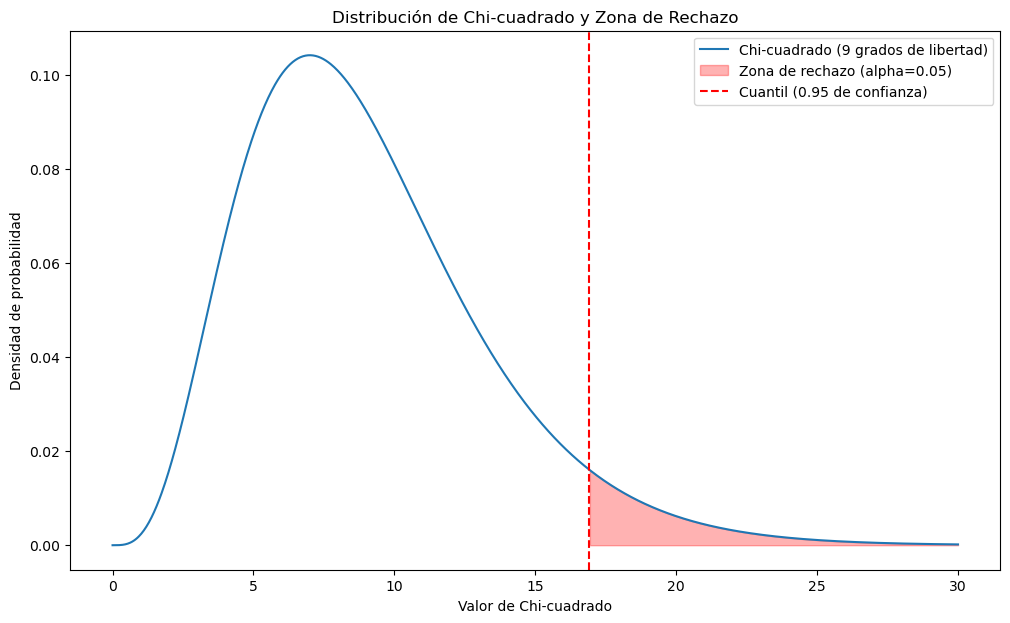

In [58]:
graficar_chi2_test(9)

A continuación se muestran los resultados de aplicar el test de Chi2 a las muestras generadas.

Comenzamos con nuestra pequeña muestra de 32 numeros

Limite superior: 16.92 
Estadistico: 8.63 
No hay evidencia para rechazar H0
Frecuencias:  [3, 0, 2, 4, 4, 5, 4, 2, 6, 2]


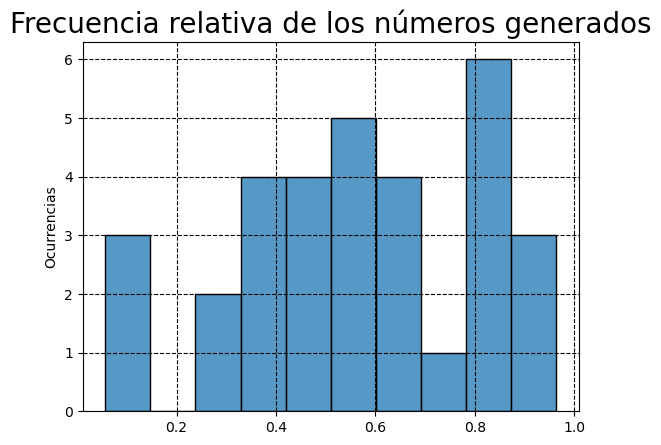

In [16]:
frecuencia_chi2_test(MUESTRA_32)
graficar_ocurrencias(MUESTRA_32)

En el grafico se pueden observar "rangos" con muchas mas ocurrencias que otros, y en los que no hubo ninguna, de todas formas segun el test no tenemos evidencia suficiente para rechazar H0.

Continuamos con la muestra de 256 elementos.

Limite superior: 16.92 
Estadistico: 13.30 
No hay evidencia para rechazar H0
Frecuencias:  [21, 25, 26, 25, 26, 27, 41, 18, 21, 26]


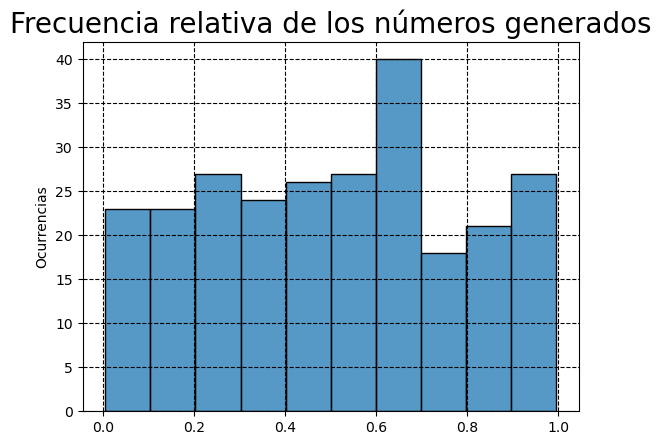

In [17]:
frecuencia_chi2_test(MUESTRA_256)
graficar_ocurrencias(MUESTRA_256)

Aumentando el tamaño de la muestra podemos ver que ya todos los "rangos" estan mas o menos poblados, con algunos picos, pero es suficiente para ver que puede acercarse a una distribucion uniforme, además como en el caso anterior no tenemos evidencia para rechazar nuestra hipotesis nula.

Limite superior: 16.92 
Estadistico: 7.24 
No hay evidencia para rechazar H0
Frecuencias:  [412, 410, 398, 426, 397, 403, 392, 423, 388, 447]


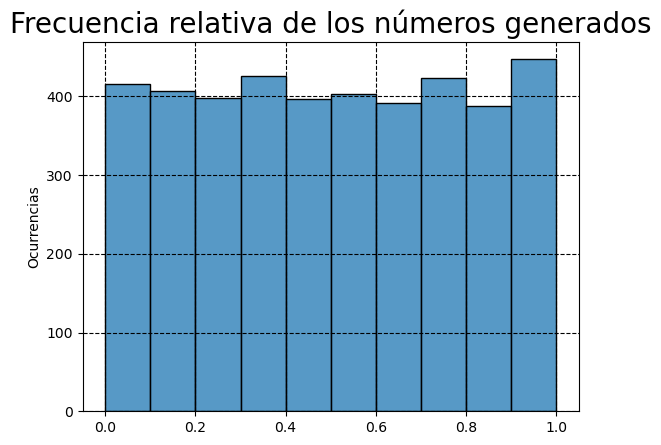

In [18]:
frecuencia_chi2_test(MUESTRA_4096)
graficar_ocurrencias(MUESTRA_4096)

Ya con la muestra de 4096 elementos, todos los rangos son poblados en forma "uniforme" y de nuevo no evidencia para rechazar H0, por lo que la muestra mas grande en principio sigue una distribucion uniforme.

## Test Serial

Con este test buscamos aplicar el test de Chi2 sobre las ocurrencias de los pares de numeros consecutivos de la muestra
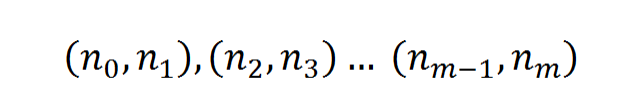

para ver si se asemeja a una distribucion uniforme.

In [19]:
def ocurrencias_pares(muestra):
    ocurrencias = dict()
    n = 0
    while n < len(muestra) - 1:
        tupla = (discretizador(muestra[n]), discretizador(muestra[n + 1]))
        aux = ocurrencias.get(tupla, 0)
        if aux == 0:
            ocurrencias[tupla] = 1
        else:
            ocurrencias[tupla] = aux + 1

        n = n + 2

    return ocurrencias

In [20]:
# Definimos nuestro test
# H0, nuestra hipotesis nula es que la probabilidad de nuestra muestra se distribuye de manera uniforme
def serial_chi2_test(muestra):
    resultados = ocurrencias_pares(muestra)
    print(resultados)
    lanzamientos = 0
    for _, valor in resultados.items():
        lanzamientos = lanzamientos + valor

    print(lanzamientos)
    D2 = sum([(fO - 1 / 100 * lanzamientos) ** 2 for _, fO in resultados.items()]) / (
        1 / 100 * lanzamientos
    )
    limiteSuperior = chi2.ppf(1 - ALPHA, df=99)
    print("Limite superior: {:.2f} ".format(limiteSuperior))
    print("Estadistico: {:.2f} ".format(D2))
    if D2 <= limiteSuperior:
        print("No hay evidencia para rechazar H0")
    else:
        print("Rechazamos H0")

Aplicamos los test sobre las 3 muestras...

In [21]:
serial_chi2_test(MUESTRA_32)

{(6, 6): 1, (8, 9): 2, (7, 9): 1, (6, 9): 1, (5, 7): 1, (7, 4): 1, (5, 3): 1, (9, 1): 1, (10, 3): 1, (4, 5): 1, (6, 5): 1, (6, 4): 1, (10, 9): 1, (1, 4): 1, (1, 7): 1}
16
Limite superior: 123.23 
Estadistico: 82.90 
No hay evidencia para rechazar H0


In [22]:
serial_chi2_test(MUESTRA_256)

{(1, 4): 2, (9, 10): 3, (8, 2): 1, (9, 9): 1, (10, 5): 2, (8, 9): 2, (5, 6): 2, (8, 7): 2, (2, 8): 3, (7, 6): 5, (2, 6): 1, (10, 8): 1, (6, 2): 2, (5, 5): 3, (3, 2): 1, (8, 8): 1, (5, 3): 2, (7, 2): 3, (7, 3): 2, (7, 4): 4, (10, 10): 2, (7, 5): 3, (4, 7): 4, (5, 10): 3, (7, 1): 1, (1, 10): 3, (7, 7): 1, (3, 4): 2, (4, 4): 1, (6, 1): 3, (5, 7): 2, (2, 7): 4, (3, 7): 2, (2, 10): 2, (3, 5): 2, (2, 4): 3, (9, 1): 1, (1, 7): 1, (9, 7): 1, (10, 9): 1, (10, 1): 1, (8, 1): 1, (1, 5): 2, (3, 10): 1, (4, 9): 1, (1, 3): 1, (6, 9): 2, (3, 6): 1, (6, 10): 1, (10, 3): 2, (4, 1): 2, (7, 9): 1, (3, 3): 1, (6, 6): 3, (1, 2): 2, (9, 4): 1, (3, 8): 3, (8, 3): 1, (6, 4): 3, (6, 7): 1, (3, 9): 1, (10, 7): 1, (9, 5): 1, (9, 3): 2, (4, 8): 1, (7, 8): 1, (5, 9): 1, (2, 2): 1, (3, 1): 1, (7, 10): 1, (9, 2): 1}
128
Limite superior: 123.23 
Estadistico: 66.13 
No hay evidencia para rechazar H0


In [23]:
serial_chi2_test(MUESTRA_4096)

{(9, 6): 17, (8, 5): 25, (2, 1): 25, (10, 4): 23, (10, 9): 18, (2, 10): 18, (9, 1): 23, (2, 6): 21, (7, 2): 18, (2, 8): 27, (9, 9): 14, (9, 5): 13, (6, 2): 19, (5, 1): 21, (1, 10): 18, (7, 4): 17, (5, 5): 26, (8, 1): 25, (9, 4): 23, (10, 1): 24, (9, 3): 14, (1, 8): 20, (4, 10): 26, (8, 8): 19, (2, 4): 26, (6, 5): 18, (1, 4): 22, (2, 2): 25, (1, 2): 11, (3, 9): 23, (10, 7): 24, (8, 6): 22, (7, 1): 20, (6, 7): 17, (3, 10): 22, (10, 3): 28, (7, 7): 13, (6, 9): 19, (6, 8): 15, (8, 10): 16, (4, 6): 25, (4, 3): 25, (3, 3): 21, (2, 3): 20, (10, 6): 22, (5, 10): 20, (3, 7): 16, (3, 1): 18, (1, 1): 20, (4, 9): 18, (7, 10): 20, (4, 7): 23, (1, 9): 14, (7, 5): 16, (5, 7): 20, (9, 8): 26, (10, 5): 25, (3, 5): 18, (3, 2): 24, (1, 3): 16, (8, 9): 24, (6, 4): 21, (2, 7): 18, (3, 8): 25, (3, 4): 19, (5, 8): 21, (5, 3): 17, (6, 3): 18, (4, 5): 24, (5, 2): 15, (4, 8): 18, (6, 1): 20, (1, 6): 29, (7, 9): 18, (5, 6): 23, (10, 8): 23, (9, 7): 33, (7, 8): 19, (9, 2): 22, (10, 10): 28, (7, 3): 20, (2, 5): 19

Podemos observar que para las 3 muestras, no tenemos evidencia suficiente para rechazar que no sigan una distribucion uniforme.

## Extra - Test Espectral

Con este test buscaremos ver representado en gráficos si nuestras muestras generadas forman patrones, que indicarían si los números están relacionados de alguna manera, lo que significa que no son 'perfectamente' pseudo aleatorios.

In [24]:
def graficar_puntos(muestra):
    length = len(muestra)
    n_obs = muestra[: length - 1]
    n_plus_1_obs = muestra[1:length]

    sns.scatterplot(x=n_obs, y=n_plus_1_obs, alpha=0.5, edgecolor="black").set(
        xlabel="n observaciones", ylabel="n+1 observaciones"
    )
    plt.grid(linestyle="--", color="black")
    plt.title("Test espectral")
    plt.show()

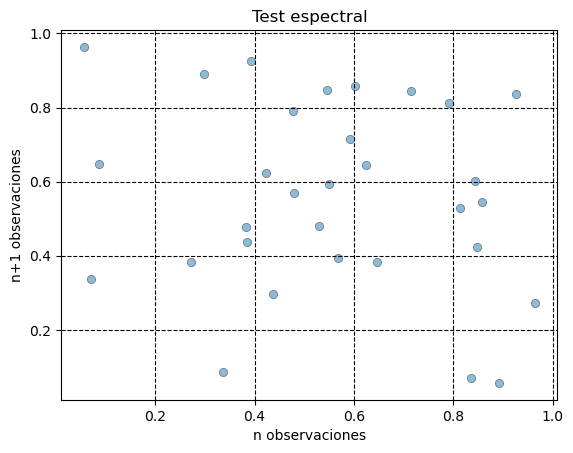

In [25]:
graficar_puntos(MUESTRA_32)

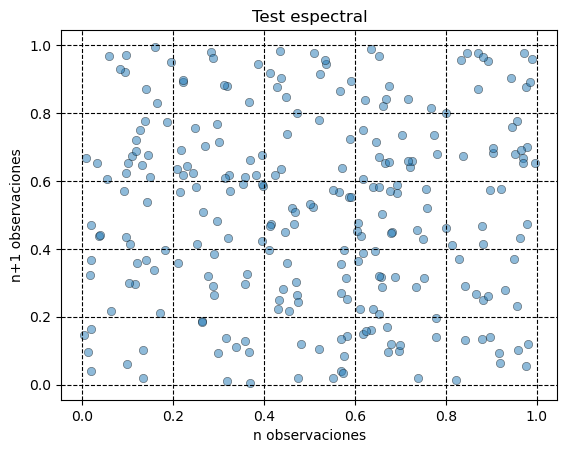

In [26]:
graficar_puntos(MUESTRA_256)

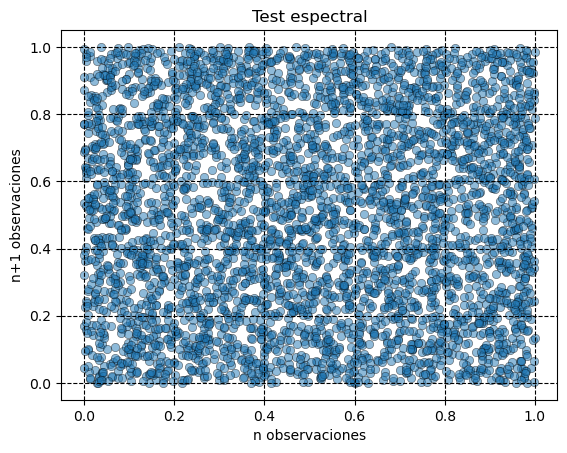

In [27]:
graficar_puntos(MUESTRA_4096)

Podemos observar que a medida que la muestra crece, los puntos tienden a ocupar todo el espacio y no a agruparse en zonas especificas. A continuación lo observaremos en 3 dimensiones para corroborar...

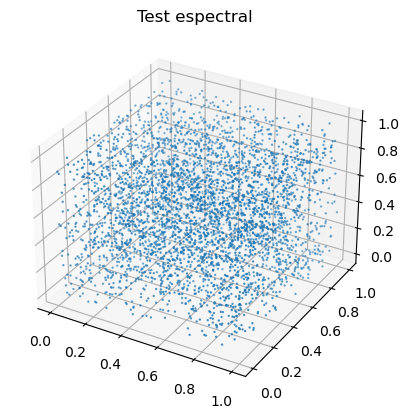

In [28]:
def graficar_puntos_3d(muestra):
    length = len(muestra)
    # x = muestra[:length - 2]
    # y = muestra[1:length - 1]
    # z = muestra[2:length]
    x = muestra[: length - 2]
    y = muestra[1 : length - 1]
    z = muestra[2:length]

    ax = plt.subplot(111, projection="3d")
    ax.scatter(x, y, z, s=0.5)
    plt.title("Test espectral")
    plt.show()


graficar_puntos_3d(MUESTRA_4096)

En este ultimo gráfico podemos corroborar lo mismo que observamos en los gráficos de 2 dimensiones. Lo que nos permite afirmar que no existe un patrón entre las muestras observadas.



---



# Ejercicio 3
Para la siguiente densidad de probabilidad, se pide:

a) Definir la función de densidad de probabilidad.

b) Calcular y graficar la función de probabilidad acumulada y su inversa. 

c) Utilizando el generador de números aleatorios implementado en el segundo ítem del ejercicio 1, genere 
números al azar con la distribución propuesta. 

d) Realice los gráficos que considere necesarios para mostrar la distribución de números al azar generados. 

![densidad ej3](densidad_ej3.png)

## a)

Calculado a mano, llegamos a que la función de densidad de probabilidad es una función partida de la siguiente forma:

$f_{x}(x) = \begin{cases}
0 & \text{si } x < 1 \\
\frac{1}{15}x - \frac{1}{15} & \text{si } 1 \leq x < 4 \\
-\frac{2}{45}x + \frac{17}{45} & \text{si } 4 \leq x < 6 \\
\frac{1}{9} & \text{si } 6 \leq x < 10 \\
-\frac{1}{9}x + \frac{10}{9} & \text{si } 9 \leq x < 10 \\
0 & \text{si } x \geq 10
\end{cases}$

In [29]:
def fdp(x):
    if x <= 1:
        return 0
    if x <= 4:
        return (1 / 15) * x + (-1 / 15)
    if x <= 6:
        return (-2 / 45) * x + (17 / 45)
    if x <= 9:
        return 1 / 9
    if x <= 10:
        return (-1 / 9) * x + (10 / 9)
    else:
        return 0

Graficando, obtenemos lo siguiente:

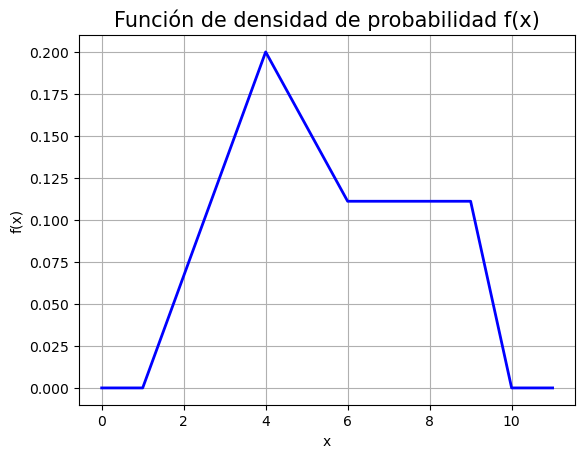

In [30]:
plt.plot([fdp(x) for x in range(12)], linewidth=2, color="b")
plt.title("Función de densidad de probabilidad f(x)", fontsize=15)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

Observemos que es el mismo gráfico que el dado por el enunciado.

## b)

Nos piden calcular la probabilidad acumulada. Lo que hacemos es calcular la integral desde menos infinito hasta x de la función de densidad que calculamos en el inciso anterior.

A mano llegamos a lo siguiente

$F_x(x) = \begin{cases}
0 & \text{si } x < 1 \\
\frac{1}{30}x^2 - \frac{1}{15}x & \text{si } 1 \leq x < 4 \\
\frac{3}{10} - \frac{1}{45}x^2 + \frac{17}{45}x & \text{si } 4 \leq x < 6 \\
\frac{11}{18} + \frac{1}{9}x & \text{si } 6 \leq x < 9 \\
\frac{17}{18} - \frac{1}{18}x^2 + \frac{10}{9}x & \text{si } 9 \leq x < 10 \\
1 & \text{si } x \geq 10
\end{cases}$

In [31]:
def func_proba_acum(x):
    t = Symbol("t")
    if x <= 1:
        return 0
    if x <= 4:
        # La función lambda toma como argumento a x, integra con respecto a la variable t desde 1 hasta x, y finalmente evalúa en x.
        return (lambda x: integrate((1 / 15) * t + (-1 / 15), (t, 1, x)))(x)
    if x <= 6:
        return 3 / 10 + (lambda x: integrate((-2 / 45) * t + (17 / 45), (t, 4, x)))(x)
    if x <= 9:
        return 11 / 18 + (lambda x: integrate(1 / 9, (t, 6, x)))(x)
    if x <= 10:
        return 17 / 18 + (lambda x: integrate((-1 / 9) * t + (10 / 9), (t, 9, x)))(x)
    return 1

Observamos un gráfico de la función de probabilidad acumulada.

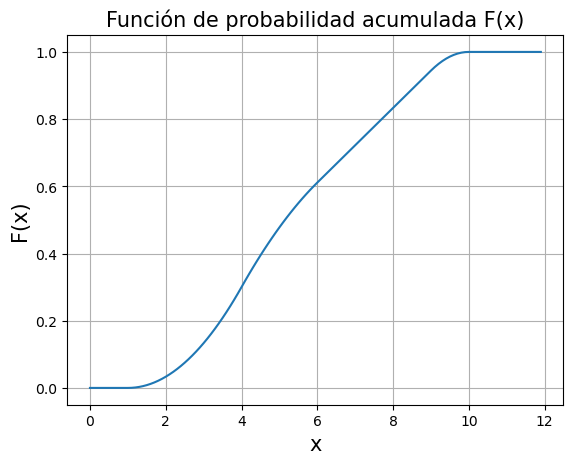

In [32]:
plt.plot(np.arange(0, 12, 0.1), [func_proba_acum(x) for x in np.arange(0, 12, 0.1)])
plt.title("Función de probabilidad acumulada F(x)", fontsize=15)
plt.xlabel("x", fontsize=15)
plt.ylabel("F(x)", fontsize=15)
plt.grid(True)

plt.show()

O tenemos la opción de que la computadora haga el trabajo por nosotros, evitando cometer errores accidentales en el cálculo de integrales (a pesar de haber corroborado que no lo hayan).

In [33]:
def func_proba_acum(x):
    t = Symbol("t")
    if x <= 1:
        return 0
    if x <= 4:
        # La función lambda toma como argumento a x, integra con respecto a la variable t desde 1 hasta x, y finalmente evalúa en x.
        return (lambda x: integrate((1 / 15) * t + (-1 / 15), (t, 1, x)))(x)
    if x <= 6:
        return integrate((1 / 15) * t + (-1 / 15), (t, 1, 4)) + (
            lambda x: integrate((-2 / 45) * t + (17 / 45), (t, 4, x))
        )(x)
    if x <= 9:
        return (
            integrate((1 / 15) * t + (-1 / 15), (t, 1, 4))
            + integrate((-2 / 45) * t + (17 / 45), (t, 4, 6))
            + (lambda x: integrate(1 / 9, (t, 6, x)))(x)
        )
    if x <= 10:
        return (
            integrate((1 / 15) * t + (-1 / 15), (t, 1, 4))
            + integrate((-2 / 45) * t + (17 / 45), (t, 4, 6))
            + integrate(1 / 9, (t, 6, 9))
            + (lambda x: integrate((-1 / 9) * t + (10 / 9), (t, 9, x)))(x)
        )
    return 1

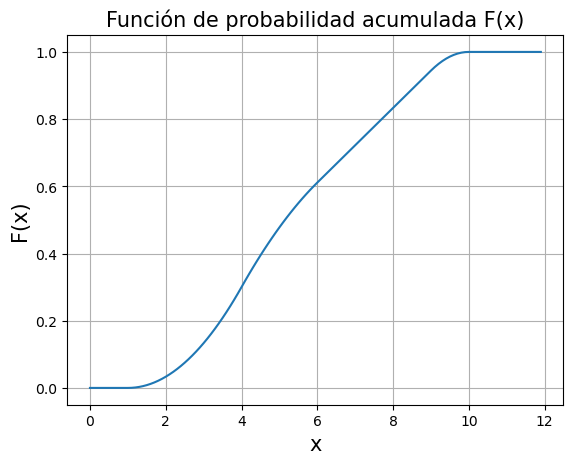

In [34]:
plt.plot(np.arange(0, 12, 0.1), [func_proba_acum(x) for x in np.arange(0, 12, 0.1)])
plt.title("Función de probabilidad acumulada F(x)", fontsize=15)
plt.xlabel("x", fontsize=15)
plt.ylabel("F(x)", fontsize=15)
plt.grid(True)

plt.show()

Observamos que los gráficos, tanto el calculado a mano como el calculado por la computadora, son iguales. Por lo que podemos afirmar que el cálculo de la integral fue correcto.

Para calcular la inversa, utilizamos el método de la transformada inversa aplicando la transformación $F_{x}^{-1}(u) = min\{x \in \mathbb{R} : F_{x}(x) \geq u\} \space , \space u \in (0,1)$ a cada tramo, generamos entonces la siguiente función:

$F_{x}^{-1}(u) = \begin{cases}
1 + \sqrt{30u} & \text{si } 0 \leq u < \frac{3}{10} \\
\frac{17}{2}-\sqrt{-45*(u-\frac{3}{4})} & \text{si } \frac{3}{10} \leq u < \frac{11}{18} \\
\frac{1}{2} + 9u & \text{si } \frac{11}{18} \leq u < \frac{17}{18} \\
10-\sqrt{-18*(u-1)} & \text{si } \frac{17}{18} \leq u < 1
\end{cases}$

In [35]:
def inversa_func_proba_acum(u):
    if u <= 3 / 10:
        return math.sqrt(30 * u) + 1
    if u <= 11 / 18:
        return 17 / 2 - math.sqrt(-45 * (u - 3 / 4))
    if u <= 17 / 18:
        return 1 / 2 + 9 * u
    return 10 - math.sqrt(-18 * (u - 1))

Graficamos la función de probabilidad acumulada inversa

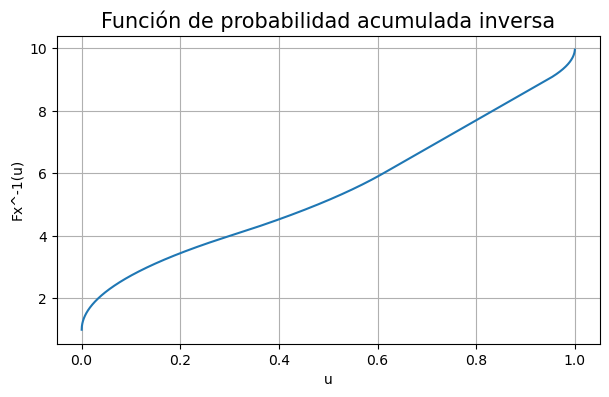

In [36]:
plt.figure(figsize=(7, 4))
plt.plot(
    np.arange(0, 1, 0.0001),
    [inversa_func_proba_acum(u) for u in np.arange(0, 1, 0.0001)],
)
plt.title("Función de probabilidad acumulada inversa", fontsize=15)
plt.xlabel("u")
plt.ylabel("Fx^-1(u)")
plt.grid(True)

plt.show()

## c)

queremos generar números aleatorios con la distribución acumulada inversa utilizando el generador Mersenne Twister. Vamos a generar una muestra de 500k números con la distribución pedida.

In [37]:
N = 500000
mt = MT19937(0)
muestras_ej3 = [inversa_func_proba_acum(mt.next_uniforme()) for _ in range(N)]

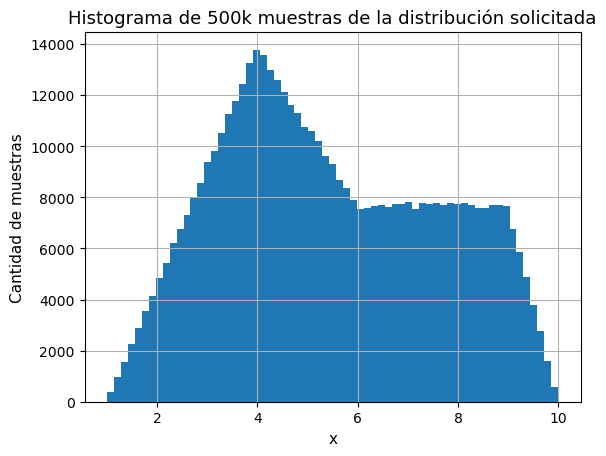

In [38]:
plt.hist(muestras_ej3, bins=65)
plt.title("Histograma de 500k muestras de la distribución solicitada", fontsize=13)
plt.xlabel("x", fontsize=11)
plt.ylabel("Cantidad de muestras", fontsize=11)
plt.grid(True)
plt.show()

Podemos concluir que el histograma generado tiene la misma forma que la función de densidad que nos pidieron en el enunciado, por lo que a través de los números generados aleatoriamente observamos que la inversa de la función encontrada es la correcta.



---



# Ejercicio 4

La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ vehículos/hora. En el trabajo práctico se incluye un archivo con números pseudoaleatorios que representan los tiempos entre arribos de dichos vehículos.
* Realice una estimación de la tasa de arribos y proponga un test para evaluar si los números pseudoaleatorios provistos siguen la distribución esperada. 
* Utilizando el generador implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes. Graficar la cantidad de arribos en función del tiempo. 
* Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes probabilidades:
    1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
    2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
    3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.
    Comparar con los valores teóricos.

## Cálculo de $\lambda$

Nos dicen que la llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa $\lambda$.

Como se supone que las llegadas de los vehículos al estacionamiento son independientes 1 a 1, y se distribuyen de forma idéntica, nos están diciendo que $\text{T = tiempo entre 2 llegadas consecutivas de cada vehículo al estacionamiento}$, $T \sim \boldsymbol{\varepsilon}(\lambda)$.

Y a su vez, podemos saber por propiedades de la distribuición de Poisson, que el tiempo $\text{G = "tiempo hasta la llegada al estacionamiendo del k-ésimo vehículo"}$, $G \sim \Gamma(k, \lambda)$.

Por lo tanto, podemos aprovechar que la media de una distribuición $\Gamma(k, \lambda)$ es $\frac{k}{\lambda}$, para determinar de forma aproximada la media de G, y en base a la suma total, despejar $\lambda$.\
$\lambda = \frac{k}{tiempo\ total}$

In [39]:
# Leemos el archivo de entrada
tiempos_entre_arribos = "tiempos_entre_arribos.txt"
with open(tiempos_entre_arribos, "r") as archivo:
    tiempos_en_horas = [float(line) for line in archivo]

# Sumamos todos los tiempos de arribo para obtener el tiempo total dado por el archivo
tiempo_total = sum(tiempos_en_horas)
print(f"El tiempo total hasta el último arribo fue de {tiempo_total} horas")

# Obtenemos la cantidad de arribos en el archivo
cantidad_arribos = len(tiempos_en_horas)

# Calculamos lambda
lambda_horas = cantidad_arribos / tiempo_total
print(f"Lambda estimado = {lambda_horas} vehículos/hora")

El tiempo total hasta el último arribo fue de 1011.1994386169154 horas
Lambda estimado = 9.889245996494681 vehículos/hora


Queremos aportar información adicional:
* el promedio del tiempo entre llegadas de vehículos al estacionamiento.
* el máximo tiempo de espera hasta la llegada de un vehículo al estacionamiento.
* el mínimo tiempo de espera hasta la llegada de un vehículo al estacionamiento.

In [40]:
print(
    f"El tiempo promedio entre llegadas de vehículos es de {np.mean(tiempos_en_horas)} horas"
)
print(
    f"El tiempo entre llegadas de vehículos máximo es de {np.max(tiempos_en_horas)} horas"
)
print(
    f"El tiempo entre llegadas de vehículos mínimo es de {np.min(tiempos_en_horas)} horas"
)

El tiempo promedio entre llegadas de vehículos es de 0.10111994386169156 horas
El tiempo entre llegadas de vehículos máximo es de 0.9507137156953789 horas
El tiempo entre llegadas de vehículos mínimo es de 9.517908856170662e-06 horas


Como los tiempos entre llegadas de los vehículos son muy pequeños si hablamos en unidades de horas, lo transformamos a minutos para que sea más fácil de interpretar.

In [41]:
tiempos_en_minutos = [tiempo * 60 for tiempo in tiempos_en_horas]
lambda_minutos = lambda_horas / 60

print(
    f"El tiempo promedio entre llegadas de vehículos es de {np.mean(tiempos_en_minutos)} minutos"
)
print(
    f"El tiempo entre llegadas de vehículos máximo es de {np.max(tiempos_en_minutos)} minutos"
)
print(
    f"El tiempo entre llegadas de vehículos mínimo es de {np.min(tiempos_en_minutos)} minutos"
)

print(f"Lambda estimado = {lambda_minutos} vehículos/minúto")

El tiempo promedio entre llegadas de vehículos es de 6.067196631701494 minutos
El tiempo entre llegadas de vehículos máximo es de 57.04282294172273 minutos
El tiempo entre llegadas de vehículos mínimo es de 0.0005710745313702397 minutos
Lambda estimado = 0.16482076660824468 vehículos/minúto


Esta información nos serivirá a la hora de tomar la decisión, ya que podemos decir que llega aproximadamente 1 vehículo cada 6 minutos.

## Test para evaluar si los números pseudoaleatorios del archivo siguen una distribuición de Poission de la tasa propuesta

Utilizamos el Test de Kolmogorov-Smirnov ya definido en el ejercicio 2.

Estadistico = 0.9282
p-value     = 0.0

Rechazamos H0


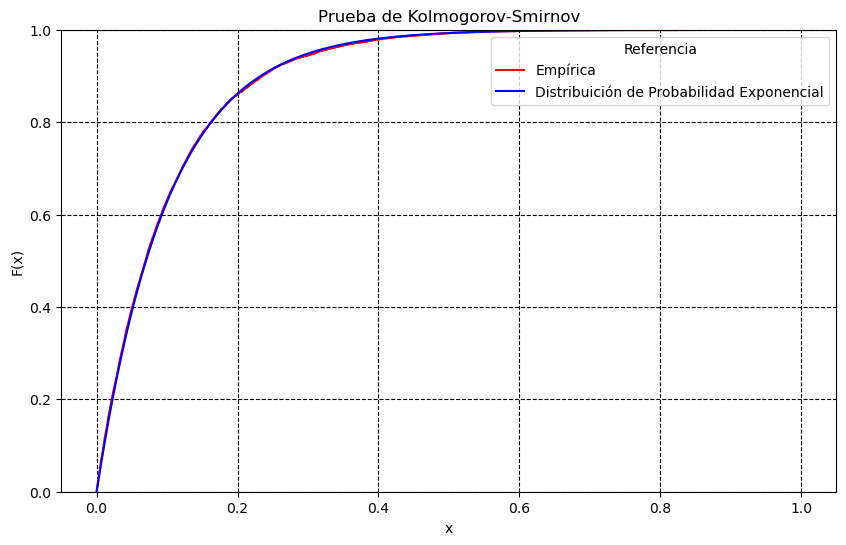

In [42]:
x = np.linspace(0, 1, len(tiempos_en_horas))
dist_exp = stats.expon.cdf(x, scale=1 / lambda_horas)

kolmogorov_test(tiempos_en_horas, dist_exp)
graficar_kolmogorov_test(
    tiempos_en_horas, dist_exp, "Distribuición de Probabilidad Exponencial"
)

## Utilizando el generador implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes.

Para realizar la simulación de la llegada de vehículos durante un mes, utilizamos el método de la transformada inversa, ya que tenemos una $\boldsymbol{\varepsilon}(\lambda = 9.889...)$, podemos simular arribos hasta los 31 días del mes o 44640 minutos, que son 31 días en minutos.\
Decidimos usar la distribuición exponencial debido a que calcular la transdormada inversa de una Poisson es muy complejo.

### Calculamos la transformada inversa de la distribuición exponencial

Teniendo una distribuición uniforme $U(0, 1)$, podemos calcular la transformada inversa de la distribuición exponencial de la siguiente forma:

$F_U(u) = F_T(t)$. Despejamos t en función de u:

$$F_X(t_i) = 1-e^{- \lambda t_i} = F_U(u_i) = u_i$$
$$e^{- \lambda t_i} = 1 - u_i$$
$$- \lambda t_i = ln(1- u_i)$$
$$t_i = - \frac{1}{\lambda} \cdot ln(1 - u_i)$$




 y obtenemos la siguiente fórmula:

$$t = -\frac{1}{\lambda} \cdot ln(1 - u)$$

Recordamos que $T = tiempo\ entre\ 2\ llegadas\ consecutivas\ de\ cada\ vehículo\ al\ estacionamiento$ y que $T \sim Exp(\lambda)$

### Simulación de arribos de vehículos durante un mes

Simulamos llegadas de vehículos hasta los 44640 minutos y lo guardamos en un archivo para no simularlo muchas veces

Cantidad de arribos simulados: 7311


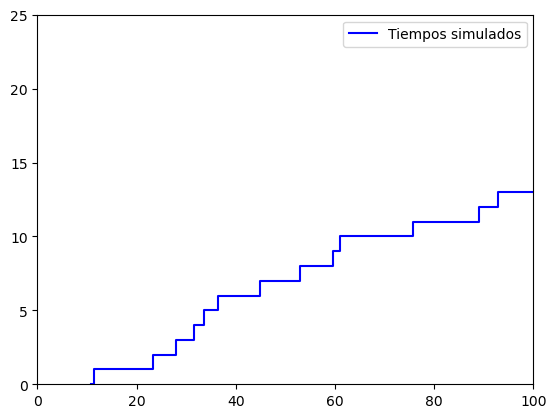

In [43]:
generador_aleatorio = MT19937(0)
tiempos_simulados = []
tiempo_arribo_actual = 0

while tiempo_arribo_actual < 44640:
    tiempo_arribo_actual += (
        -np.log(1 - generador_aleatorio.next_uniforme()) / lambda_minutos
    )
    tiempos_simulados.append(tiempo_arribo_actual)
tiempos_simulados.pop()

print(f"Cantidad de arribos simulados: {len(tiempos_simulados)}")

# Graficamos los tiempos simulados
plt.step(
    tiempos_simulados,
    range(len(tiempos_simulados)),
    where="post",
    label="Tiempos simulados",
    color="b",
)

# Hacemos un zoom para ver algunos arribos
plt.xlim(0, 100)
plt.ylim(0, 25)
plt.legend()
plt.show()

## Generar 1000 realizaciones del proceso de Poisson para estimar probabilidades

In [44]:
generador_aleatorio = MT19937(0)
tiempos_simulados = []

for _ in range(1000):
    tiempo_actual = 0
    vuelta_i = []
    while tiempo_actual < 4320:
        tiempo_actual += (
            -np.log(1 - generador_aleatorio.next_uniforme()) / lambda_minutos
        )
        vuelta_i.append(tiempo_actual)
    vuelta_i.pop()
    tiempos_simulados.append(vuelta_i)

### 1. Probabilidad de que el primer vehículo arribe antes de los 10 minutos.

In [45]:
cant_primeros_arribos_10_min = 0

for i in range(len(tiempos_simulados)):
    if tiempos_simulados[i][0] < 10:
        cant_primeros_arribos_10_min += 1

print(cant_primeros_arribos_10_min / len(tiempos_simulados))

0.797


Lo comprobamos de forma teórica.

$N(t): "Cantidad\ de\ vehículos\ que\ arriban\ en\ un\ intervalo\ [0, t]",\ N(t) \sim Poi(\mu = \lambda \cdot t)$.\
En este caso $\lambda = 0.165...$ y $t = 10$.\
Por lo tanto: $$N(10) \sim Poi(\mu = 1.65...)$$
Calculamos la probabilidad de que el primer vehículo arribe antes de los 10 minutos:
$$P(N \geq 1) = 1 - P(N = 0) = 1 - \frac{\mu^0 \cdot e^{-\mu}}{0!} = 1 - e^{-1.65...} \approx 0.80795$$

El resultado teórico es aproximado al resultado obtenido por simulación.

Si incrementamos la cantidad de muestras en la simulación, el resultado se acercará más al teórico.

### 2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.

In [46]:
casos_undecimo_arribo_mayor_60 = 0

for i in range(len(tiempos_simulados)):
    if tiempos_simulados[i][10] > 60:
        casos_undecimo_arribo_mayor_60 += 1

print(casos_undecimo_arribo_mayor_60 / len(tiempos_simulados))

0.61


Lo comprobamos de forma teórica.

$G_i: "Tiempo\ hasta\ la\ llegada\ del\ i-ésimo\ vehículo\ al\ estacionamiento",\ G_i \sim \Gamma(i, \lambda)$

O puedo pensar el problema como $P(G_{11} > 60) = P(N(60) \leq 10)$ 

Como definimos en el punto anterior, $N(60) \sim Poi(\mu = 9.889...)$.

Por lo tanto, $P(N(60) \leq 10) = \sum_{x=0}^{10} \frac{\mu^x \cdot e^{-\mu}}{x!} \approx 0.5969$

### 3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

In [47]:
casos_750_vehiculos_antes_72_hs = 0

for i in range(len(tiempos_simulados)):
    if len(tiempos_simulados[i]) <= 750 or tiempos_simulados[i][749] > 72 * 60:
        continue
    casos_750_vehiculos_antes_72_hs += 1

print(casos_750_vehiculos_antes_72_hs / len(tiempos_simulados))

0.075


Lo comprobamos de forma teórica.

$P(N(4320) \geq 751) = 1 - P(N(4320) \leq 750) = 1 - \sum_{x=0}^{750} \frac{\mu^x \cdot e^{-\mu}}{x!} \approx 0.07556$



---



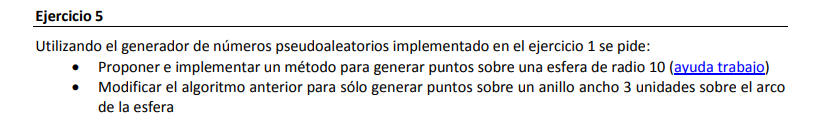

Link [ayuda](https://drive.google.com/file/d/1j9yLSLFdKLy5nOqO7Yys_rV_pv8x1Kau/view)

# Ejercicio 5:
Utilizando el generador de números pseudoaleatorios implementado en el ejercicio 1 se pide:


*   Proponer e implementar un método para generar puntos sobre una esfera de radio 10.
*   Modificar el algoritmo anterior para sólo generar puntos sobre un
anillo ancho 3 unidades sobre el arco de la esfera.





Para realizar este ejercicio vamos a utilizar coordenadas esféricas, en las cuales un punto en el espacio se define mediante tres valores: un radio (r) que toma valores de 0 a ∞, un ángulo polar (θ) que toma valores entre 0 y π, y  un ángulo azimutal (φ) que varía entre 0 y 2π. Las coordenadas cartesianas quedan entonces definidas como:
*   x = r * sin(θ) * cos(φ)
*   y = r * sin(θ) * sin(φ)
*   z = r * cos(θ)

Para generar puntos sobre una esfera de radio 10, vamos a generar por cada punto un número aleatorio entre 0 y π para definir θ, y un número aleatorio entre 0 y 2π para φ. Para esto generamos un número entre 0 y 1 y lo multiplicamos por π para definir θ, y generamos otro número entre 0 y 1 y lo multiplicamos por 2π para definir φ. El valor de r es constante e igual a 10. Una vez obtenidos θ y φ, ya podemos calcular las coordenadas cartesianas del punto con las definiciones establecidas previamente.


In [48]:
radio = 10
mt = MT19937(0)


def transformar_coordenadas_esfericas_a_cartesianas(radio, theta, phi):
    x = radio * np.sin(theta) * np.cos(phi)
    y = radio * np.sin(theta) * np.sin(phi)
    z = radio * np.cos(theta)
    return x, y, z


def generar_puntos_esfera():
    theta = mt.next_uniforme() * np.pi
    phi = mt.next_uniforme() * 2 * np.pi
    return transformar_coordenadas_esfericas_a_cartesianas(radio, theta, phi)

Para resolver el segundo punto vamos a utilizar coordenadas cilíndricas, las cuales se definen mediante tres valores: un radio (r) que respresenta la distancia al eje z y toma valores de 0 a ∞, un ángulo azimutal (φ) que varía entre 0 y 2π, y z que puede tomar valores de -∞ a ∞. Las coordenadas cartesianas quedan entonces definidas como:

*   x = r * cos(φ)
*   y = r * sen(φ)
*   z = z

Para generar puntos sobre un anillo de ancho 3 unidades sobre el arco de la esfera vamos a generar un valor aleatorio para φ y un valor aleatorio para r. En este caso z es constante e igual a 0 ya que el anillo se encuentra contenido en el plano xy (la esfera es simétrica con respecto a ese plano). El valor de r se va a encontrar dentro del rango del anillo, es decir, va a ser mayor al radio interior y menor al radio exterior. En este caso:

*   r(int) = r(esfera) - ancho/2 = 10 - 1.5 = 8.5
*   r(ext) = r(esfera) + ancho/2 = 10 + 1.5 = 11.5

Entonces, para generar un valor aleatorio para 8.5 ≤ r ≤ 11.5, generamos un número aleatorio entre 0 y 1, lo multiplicamos por 3 para ajustarlo al ancho establecido y le sumamos 8.5 para que caiga dentro del anillo que contiene al arco de la esfera. El valor de φ se genera de la misma forma que en el punto anterior (generando un número aleatorio entr 0 y 1 y multiplicandolo por 2π). El valor de z es constante como se explicó anteriormente.Luego se calculan las coordenadas cartesianas con esos valores de r y φ.

In [49]:
ancho = 3
z = 0
mt = MT19937(0)


def transformar_coordenadas_cilindricas_a_cartesianas(radio, phi, z):
    x = radio * np.cos(phi)
    y = radio * np.sin(phi)
    return x, y, z


def generar_puntos_anillo():
    radio = mt.next() * ancho + (radio - ancho / 2)
    phi = mt.next() * 2 * np.pi
    return transformar_coordenadas_cilindricas_a_cartesianas(radio, phi, z)